In [1]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
from Bio import motifs
from Bio.Seq import Seq
import random
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import pandas as pd
import os
import pickle
import requests
import ast

src_path = Path("../src")
sys.path.append(str(src_path))

from ts_tf.motifs import fetch_all_motifs, save_to_csv, fetch_all_motif_metadata, save_metadata_to_csv
import ts_tf.protein as prot
import ts_tf.custom_esm as cesm

retrieve cached motifs

In [6]:
output_file = "../results/motif/high_quality_motifs_with_pfm_pwm.csv"
motif_df = pd.read_csv(output_file)
motif_ids = list(motif_df["Motif ID"].unique())
print(f'motif_ids retrieved: {len(motif_ids)}')

motif_ids retrieved: 1912


In [7]:
motif_df

,Motif ID,Name,Collection,Position,A (PFM),C (PFM),G (PFM),T (PFM),A (PWM),C (PWM),G (PWM),T (PWM)
0,MA0634.1,ALX3,CORE,1,1251.0,2174.0,1062.0,3390.0,12.288866,13.086136,12.052568,13.727070
1,MA0634.1,ALX3,CORE,2,987.0,3402.0,1150.0,2337.0,11.946906,13.732167,12.167418,13.190442
2,MA0634.1,ALX3,CORE,3,794.0,3367.0,345.0,4510.0,11.632995,13.717248,10.430453,14.138912
3,MA0634.1,ALX3,CORE,4,7877.0,506.0,885.0,629.0,14.943431,10.982994,11.789534,11.296916
4,MA0634.1,ALX3,CORE,5,7877.0,317.0,141.0,231.0,14.943431,10.308339,9.139551,9.851749
...,...,...,...,...,...,...,...,...,...,...,...,...
21600,MA0088.1,znf143,CORE,16,4.0,5.0,0.0,1.0,4.000000,4.321928,-17.931569,2.000001
21601,MA0088.1,znf143,CORE,17,3.0,1.0,1.0,5.0,3.584963,2.000001,2.000001,4.321928
21602,MA0088.1,znf143,CORE,18,2.0,3.0,0.0,5.0,3.000001,3.584963,-17.931569,4.321928
21603,MA0088.1,znf143,CORE,19,1.0,1.0,7.0,1.0,2.000001,2.000001,4.807355,2.000001


clean up 

In [8]:
# Identify columns to group by (all except Position and matrix columns)
group_columns = list(motif_df.columns.difference(['Position', 'A (PFM)', 'C (PFM)', 'G (PFM)', 'T (PFM)', 
                                            'A (PWM)', 'C (PWM)', 'G (PWM)', 'T (PWM)']))

# Group by relevant columns and process
def process_group(group):
    pwm = group[['A (PWM)', 'C (PWM)', 'G (PWM)', 'T (PWM)']].values.tolist()
    pfm = group[['A (PFM)', 'C (PFM)', 'G (PFM)', 'T (PFM)']].values.tolist()
    return pd.Series({'pwm': pwm, 'pfm': pfm})

# Apply the transformation
motif_df = motif_df.groupby(group_columns).apply(process_group).reset_index()
print(len(motif_df[motif_df["pwm"].isnull()]))
print(len(motif_df))
motif_df = motif_df.dropna()
print(len(motif_df))

0
1912
1912


/tmp/ipykernel_2039709/3399638356.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  motif_df = motif_df.groupby(group_columns).apply(process_group).reset_index()


In [15]:
example_pfm = motif_df['pfm'][0]
example_pfm

[[10.0, 2.0, 3.0, 11.0],
 [12.0, 2.0, 1.0, 11.0],
 [4.0, 7.0, 1.0, 14.0],
 [1.0, 1.0, 0.0, 24.0],
 [2.0, 0.0, 23.0, 1.0],
 [2.0, 8.0, 0.0, 16.0],
 [0.0, 0.0, 26.0, 0.0],
 [0.0, 0.0, 26.0, 0.0],
 [0.0, 1.0, 0.0, 25.0],
 [8.0, 2.0, 0.0, 16.0],
 [13.0, 2.0, 4.0, 7.0]]

In [80]:
def compute_pwm(pfm, background_freq=None):
    """
    Compute the PWM from a given PFM.

    Args:
        pfm (list): PFM as a 2D list.
        background_freq (dict, optional): Background frequencies for A, C, G, T.
            Default is uniform distribution.

    Returns:
        np.array: PWM as a NumPy array.
    """
    if background_freq is None:
        background_freq = {"A": 0.25, "C": 0.25, "G": 0.25, "T": 0.25}

    pfm = np.array(pfm)  # Convert to NumPy array
    ppm = []
    for i in range(pfm.shape[0]):
        ppm.append(pfm[:][i] / np.sum(pfm[:][i], axis=0)) # Compute PPM for each position

    ppm = np.array(ppm)
    pwm = np.zeros(pfm.shape)
    for j in range(pfm.shape[0]):
        for k, base in enumerate(["A", "C", "G", "T"]):
            pwm[j][k] = np.log2((ppm[j][k] + 1e-3) / background_freq[base])  # Add pseudocount to avoid log(0)

    pwm = np.array(pwm)  # Transpose to match the format of the PFM

    return np.array(pwm)

In [81]:
compute_pwm(example_pfm)

[[10.  2.  3. 11.]
 [12.  2.  1. 11.]
 [ 4.  7.  1. 14.]
 [ 1.  1.  0. 24.]
 [ 2.  0. 23.  1.]
 [ 2.  8.  0. 16.]
 [ 0.  0. 26.  0.]
 [ 0.  0. 26.  0.]
 [ 0.  1.  0. 25.]
 [ 8.  2.  0. 16.]
 [13.  2.  4.  7.]]
[[0.38461538 0.07692308 0.11538462 0.42307692]
 [0.46153846 0.07692308 0.03846154 0.42307692]
 [0.15384615 0.26923077 0.03846154 0.53846154]
 [0.03846154 0.03846154 0.         0.92307692]
 [0.07692308 0.         0.88461538 0.03846154]
 [0.07692308 0.30769231 0.         0.61538462]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.03846154 0.         0.96153846]
 [0.30769231 0.07692308 0.         0.61538462]
 [0.5        0.07692308 0.15384615 0.26923077]]


array([[ 0.62523452, -1.68180554, -1.10302773,  0.76239788],
       [ 0.88764524, -1.68180554, -2.66340899,  0.76239788],
       [-0.69109255,  0.11226386, -2.66340899,  1.10959201],
       [-2.66340899, -2.66340899, -7.96578428,  1.88608486],
       [-1.68180554, -7.96578428,  1.82475219, -2.66340899],
       [-1.68180554,  0.30424144, -7.96578428,  1.30190276],
       [-7.96578428, -7.96578428,  2.00144197, -7.96578428],
       [-7.96578428, -7.96578428,  2.00144197, -7.96578428],
       [-7.96578428, -2.66340899, -7.96578428,  1.94491609],
       [ 0.30424144, -1.68180554, -7.96578428,  1.30190276],
       [ 1.00288251, -1.68180554, -0.69109255,  0.11226386]])

(11, 4)
(11, 4)
(11, 4)
(11, 4)
(11, 4)
(11, 4)
(9, 4)
(9, 4)
(9, 4)
(9, 4)
(9, 4)
(9, 4)
(15, 4)
(15, 4)
(15, 4)
(11, 4)
(11, 4)
(11, 4)
(14, 4)
(14, 4)
(14, 4)
(9, 4)
(9, 4)
(9, 4)
(6, 4)
(6, 4)
(6, 4)
(6, 4)
(6, 4)
(6, 4)
(5, 4)
(5, 4)
(5, 4)
(22, 4)
(22, 4)
(22, 4)
(15, 4)
(15, 4)
(15, 4)
(17, 4)
(17, 4)
(17, 4)
(16, 4)
(16, 4)
(16, 4)
(11, 4)
(11, 4)
(11, 4)
(16, 4)
(16, 4)
(16, 4)
(20, 4)
(20, 4)
(20, 4)
(19, 4)
(19, 4)
(19, 4)
(12, 4)
(12, 4)
(12, 4)
(8, 4)
(8, 4)
(8, 4)
(14, 4)
(14, 4)
(14, 4)
(13, 4)
(13, 4)
(13, 4)
(12, 4)
(12, 4)
(12, 4)
(12, 4)
(12, 4)
(12, 4)
(8, 4)
(8, 4)
(8, 4)
(12, 4)
(12, 4)
(12, 4)
(13, 4)
(13, 4)
(13, 4)
(8, 4)
(8, 4)
(8, 4)
(12, 4)
(12, 4)
(12, 4)
(10, 4)
(10, 4)
(10, 4)
(8, 4)
(8, 4)
(8, 4)
(11, 4)
(11, 4)
(11, 4)
(12, 4)
(12, 4)
(12, 4)
(11, 4)
(11, 4)
(11, 4)
(13, 4)
(13, 4)
(13, 4)
(9, 4)
(9, 4)
(9, 4)
(11, 4)
(11, 4)
(11, 4)
(8, 4)
(8, 4)
(8, 4)
(6, 4)
(6, 4)
(6, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(9, 4)
(9, 4)
(9, 4)
(14, 4)
(1

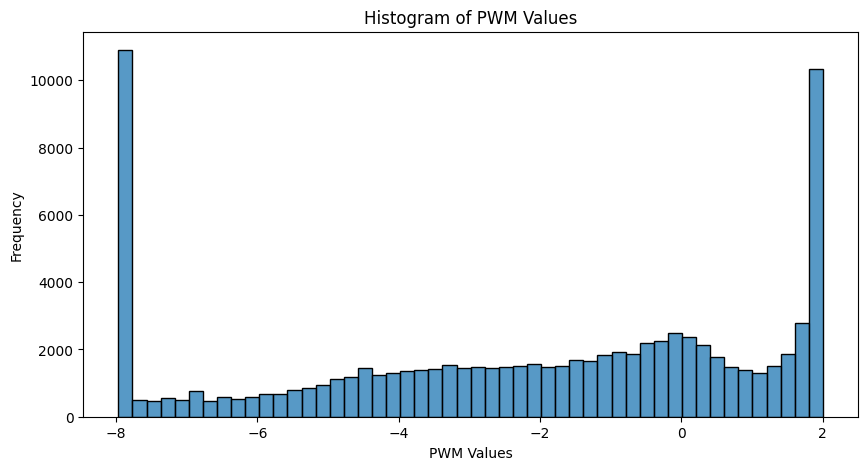

In [79]:
all_pwms = motif_df['pfm'].apply(compute_pwm)
all_pwms.apply(lambda x: x.flatten())
concatenated_pwms = np.concatenate(all_pwms.apply(lambda x: x.flatten()).values)
plt.figure(figsize=(10, 5))
sns.histplot(concatenated_pwms, bins=50)
plt.xlabel('PWM Values')
plt.ylabel('Frequency')
plt.title('Histogram of PWM Values')
plt.show()